In [1]:
import sys 
import os
import pandas as pd
ozon_bots_path = '/home/ekolodyazhnaya/shared'
sys.path.insert(0, ozon_bots_path)
current_filepath = os.path.abspath('/home/ekolodyazhnaya/ontime')
dir_path = os.path.dirname('/home/ekolodyazhnaya/ontime')
sql_dirname = os.path.join(dir_path, 'old_projects/tracker_sql_scripts')
sys.path.append(dir_path)
from clickhouse_driver import Client
from shared_utils import logger
import sqlalchemy as sa
from shared_utils import logger
import sqlalchemy as sa

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)

In [28]:
pip install seaborn

Looking in indexes: https://artifactory.s.o3.ru/artifactory/api/pypi/pypi-virtual/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 11.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
df = pd.read_excel('/home/ekolodyazhnaya/claims_sample_data.xlsx')


0        201801.0
1        201801.0
2        201801.0
3        201801.0
4        201801.0
           ...   
52147    202007.0
52148    202007.0
52149    202007.0
52150    202007.0
52151    202007.0
Name: MONTH, Length: 52152, dtype: float64

In [7]:
df

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,201801.0,AncillaryFFS,NaN,Payer F,4281.0
1,201801.0,AncillaryFFS,NaN,Payer H,2221.0
2,201801.0,AncillaryFFS,NaN,Payer O,3937.0
3,201801.0,AncillaryFFS,NaN,Payer W,268.0
4,201801.0,AncillaryFFS,ACH,Payer W,151.0
...,...,...,...,...,...
52147,202007.0,SpecialistsFFS,RADIATION ONCOLOGY,Payer F,869.0
52148,202007.0,SpecialistsFFS,REGISTERED NURSE,Payer H,99.0
52149,202007.0,SpecialistsFFS,RHEUMATOLOGY,Payer F,536.0
52150,202007.0,SpecialistsFFS,SPECIAL SERVICES,Payer H,1064.0


In [16]:
df_unrecog_data = df[df['MONTH'] == 201900]

In [20]:
df = df[df['MONTH'] != 201900]

In [22]:
df.MONTH
df.MONTH = pd.to_datetime(df['MONTH'].astype(str), format='%Y%m.0')

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [23]:
df

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,2018-01-01,AncillaryFFS,NaN,Payer F,4281.0
1,2018-01-01,AncillaryFFS,NaN,Payer H,2221.0
2,2018-01-01,AncillaryFFS,NaN,Payer O,3937.0
3,2018-01-01,AncillaryFFS,NaN,Payer W,268.0
4,2018-01-01,AncillaryFFS,ACH,Payer W,151.0
...,...,...,...,...,...
52147,2020-07-01,SpecialistsFFS,RADIATION ONCOLOGY,Payer F,869.0
52148,2020-07-01,SpecialistsFFS,REGISTERED NURSE,Payer H,99.0
52149,2020-07-01,SpecialistsFFS,RHEUMATOLOGY,Payer F,536.0
52150,2020-07-01,SpecialistsFFS,SPECIAL SERVICES,Payer H,1064.0


In [24]:
df.dtypes

MONTH               datetime64[ns]
SERVICE_CATEGORY            object
CLAIM_SPECIALTY             object
PAYER                       object
PAID_AMOUNT                float64
dtype: object

In [25]:
df.shape
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (0, 5)


In [26]:
print(df.isnull().sum())

MONTH                 0
SERVICE_CATEGORY      0
CLAIM_SPECIALTY     251
PAYER                 0
PAID_AMOUNT           0
dtype: int64


<AxesSubplot:xlabel='PAID_AMOUNT'>

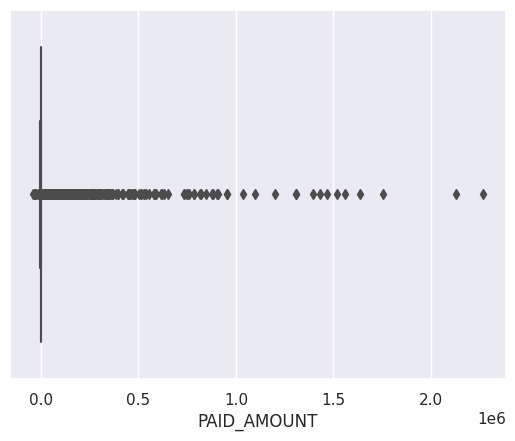

In [30]:
sns.boxplot(x=df['PAID_AMOUNT'])

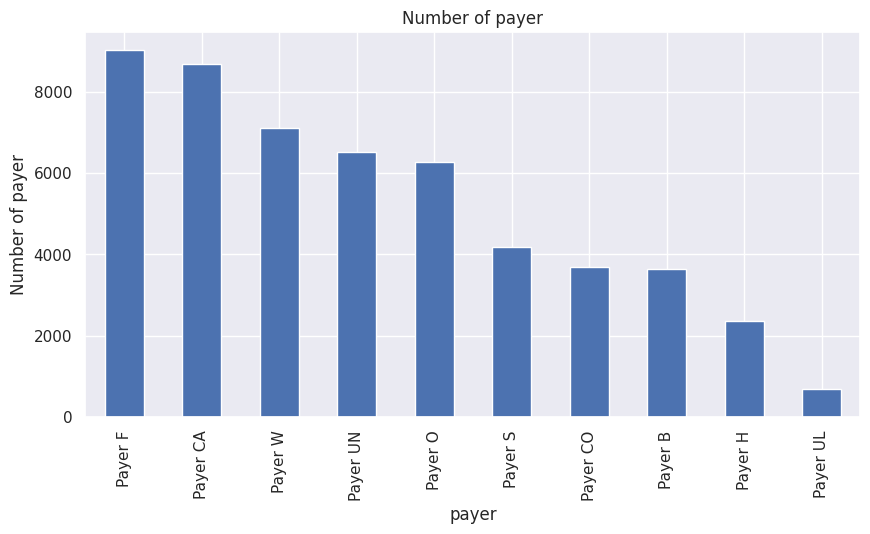

In [31]:
df.PAYER.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("Number of payer")
plt.ylabel('Number of payer')
plt.xlabel('payer');

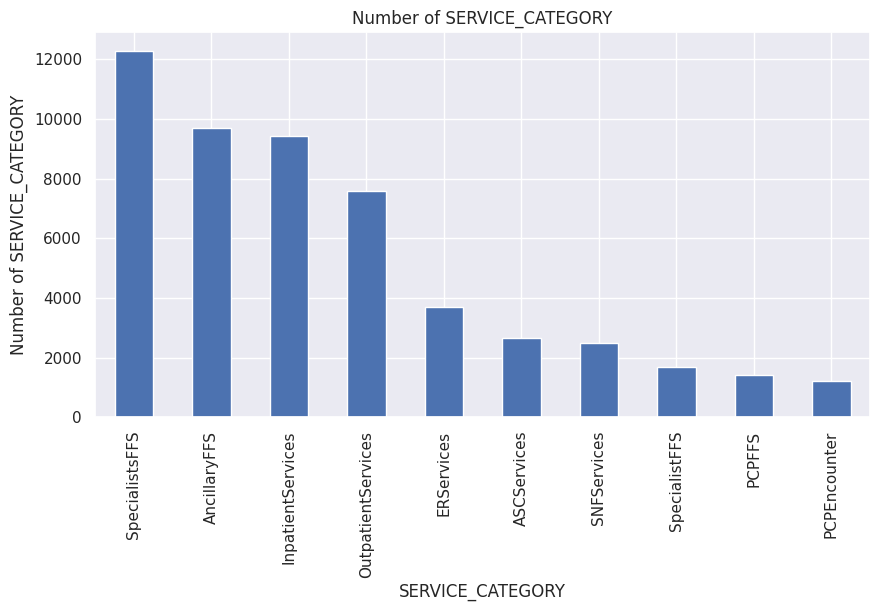

In [32]:
df.SERVICE_CATEGORY.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("Number of SERVICE_CATEGORY")
plt.ylabel('Number of SERVICE_CATEGORY')
plt.xlabel('SERVICE_CATEGORY');

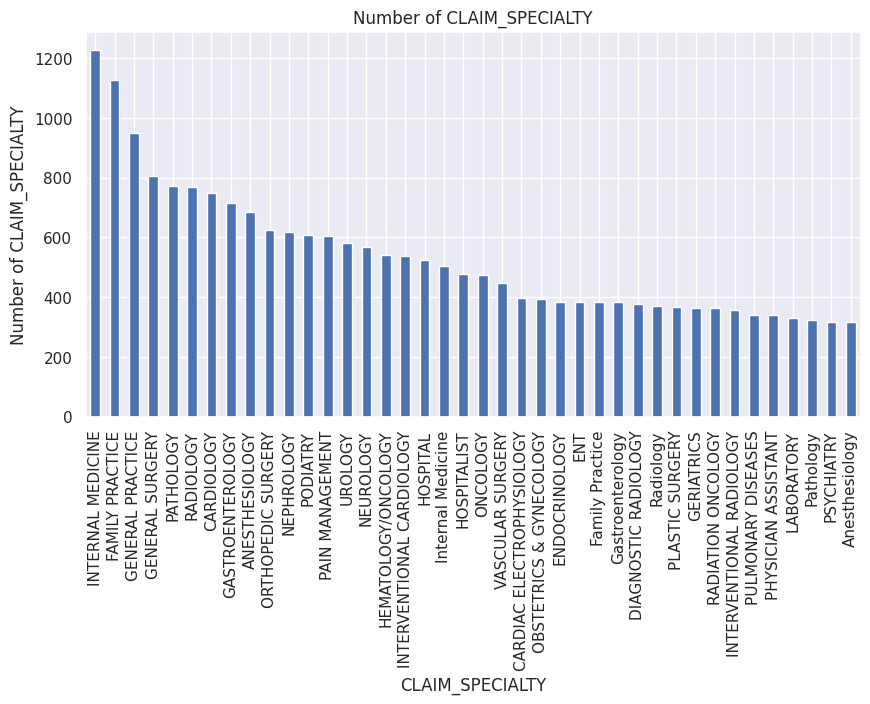

In [33]:
df.CLAIM_SPECIALTY.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("Number of CLAIM_SPECIALTY")
plt.ylabel('Number of CLAIM_SPECIALTY')
plt.xlabel('CLAIM_SPECIALTY');

,PAID_AMOUNT
PAID_AMOUNT,1.0


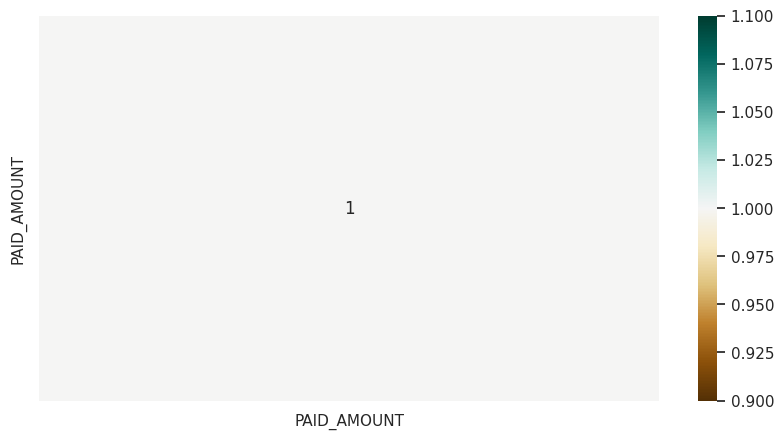

In [34]:
plt.figure(figsize=(10,5))
c= df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

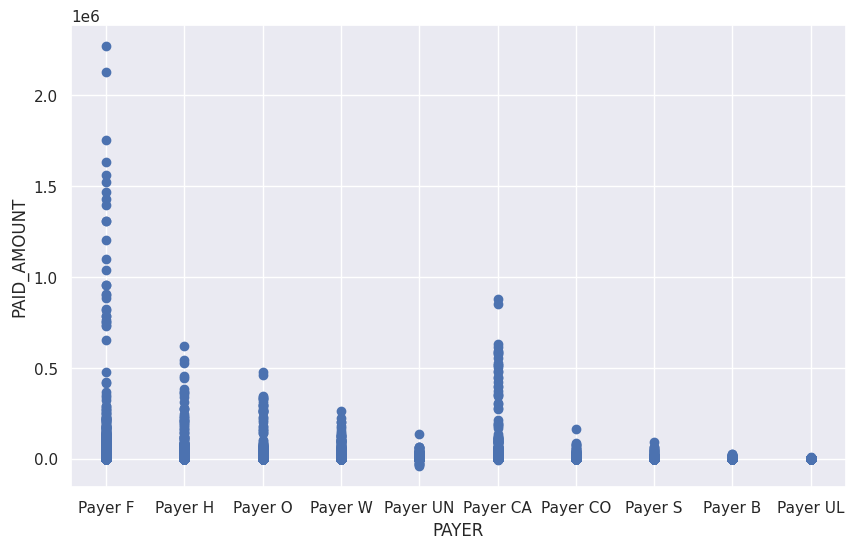

In [45]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df['PAYER'], df['PAID_AMOUNT'])
ax.set_xlabel('PAYER')
ax.set_ylabel('PAID_AMOUNT')
plt.show()

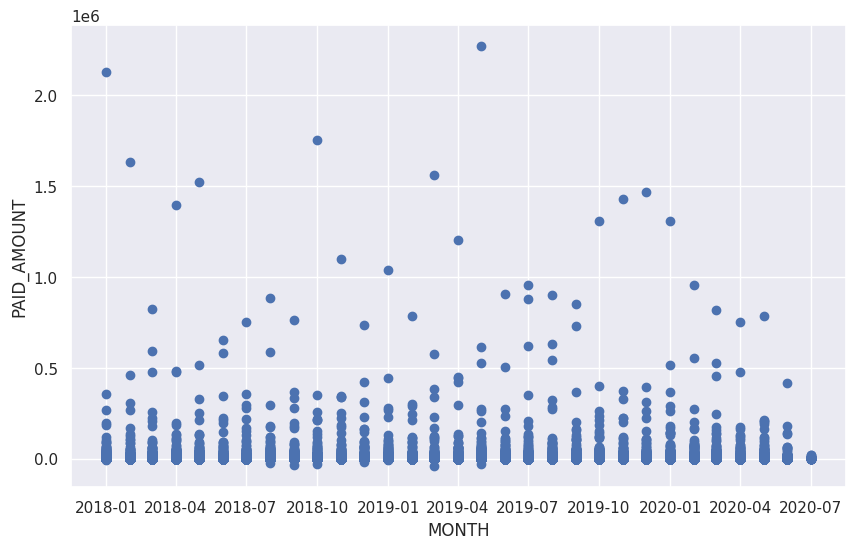

In [46]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df['MONTH'], df['PAID_AMOUNT'])
ax.set_xlabel('MONTH')
ax.set_ylabel('PAID_AMOUNT')
plt.show()

# RFM

In [35]:
df['ClientID'] = df.PAYER
df['Date'] = df.MONTH
df['Money'] = df.PAID_AMOUNT
regen = df.groupby(['ClientID'], as_index=False)[['Date']].max()
users = df.groupby(['ClientID'], as_index=True ).size()
df_frequency = df.drop_duplicates().groupby(
    by=['ClientID'], as_index=False)['Date'].count()


df_recency = df.groupby(by='ClientID',
                        as_index=False)['Date'].max()
df_recency.columns = ['ClientID', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [36]:
monet = df.groupby(['ClientID'], as_index=False)[['Money']].sum()

In [39]:

full_rfm = df_recency.merge(df_frequency, on='ClientID')
full_rfm = full_rfm.merge(monet, on='ClientID')
full_rfm.rename(columns={'Date': 'Frequency', 'Money': 'Monetary'}, inplace=True)

In [40]:
full_rfm

,ClientID,LastPurchaseDate,Recency,Frequency,Monetary
0,Payer B,2020-06-01,30,3631,2407509.0
1,Payer CA,2020-06-01,30,8681,33635443.0
2,Payer CO,2020-06-01,30,3677,5068663.0
3,Payer F,2020-07-01,0,9020,86787408.0
4,Payer H,2020-07-01,0,2349,21834697.0
5,Payer O,2020-07-01,0,6278,21419407.0
6,Payer S,2020-06-01,30,4189,3810748.0
7,Payer UL,2020-06-01,30,685,310027.0
8,Payer UN,2020-06-01,30,6526,5988435.0
9,Payer W,2020-06-01,30,7105,12180954.0


In [ ]:
# видим самую слабую страховую компанию - UL 

In [41]:
rfm_df = full_rfm
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)
 
# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100
 
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
rfm_df.head()

,ClientID,LastPurchaseDate,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,Payer B,2020-06-01,30,3631,2407509.0,44.444444,30.0,30.0
1,Payer CA,2020-06-01,30,8681,33635443.0,44.444444,90.0,90.0
2,Payer CO,2020-06-01,30,3677,5068663.0,44.444444,40.0,40.0
3,Payer F,2020-07-01,0,9020,86787408.0,100.000000,100.0,100.0
4,Payer H,2020-07-01,0,2349,21834697.0,100.000000,20.0,20.0


In [42]:
rfm_df['RFM_Score'] = 0.50*rfm_df['R_rank_norm']+0.30 * \
    rfm_df['F_rank_norm']+0.20*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['ClientID', 'RFM_Score']].head(7)

,ClientID,RFM_Score
0,Payer B,1.86
1,Payer CA,3.36
2,Payer CO,2.11
3,Payer F,5.00
4,Payer H,3.00
5,Payer O,4.00
6,Payer S,2.36


In [43]:
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] >
                                      4.5, "Top Customers",
                                      (np.where(
                                        rfm_df['RFM_Score'] > 4,
                                        "High value Customer",
                                        (np.where(
    rfm_df['RFM_Score'] > 3,
                             "Medium Value Customer",
                             np.where(rfm_df['RFM_Score'] > 1.6,
                            'Low Value Customers', 'Lost Customers'))))))
rfm_df[['ClientID', 'RFM_Score', 'Customer_segment', 'Recency', 'Frequency', 'Monetary', 'LastPurchaseDate']].head(20)

,ClientID,RFM_Score,Customer_segment,Recency,Frequency,Monetary,LastPurchaseDate
0,Payer B,1.86,Low Value Customers,30,3631,2407509.0,2020-06-01
1,Payer CA,3.36,Medium Value Customer,30,8681,33635443.0,2020-06-01
2,Payer CO,2.11,Low Value Customers,30,3677,5068663.0,2020-06-01
3,Payer F,5.00,Top Customers,0,9020,86787408.0,2020-07-01
4,Payer H,3.00,Low Value Customers,0,2349,21834697.0,2020-07-01
5,Payer O,4.00,Medium Value Customer,0,6278,21419407.0,2020-07-01
6,Payer S,2.36,Low Value Customers,30,4189,3810748.0,2020-06-01
7,Payer UL,1.36,Lost Customers,30,685,310027.0,2020-06-01
8,Payer UN,2.86,Low Value Customers,30,6526,5988435.0,2020-06-01
9,Payer W,3.11,Medium Value Customer,30,7105,12180954.0,2020-06-01


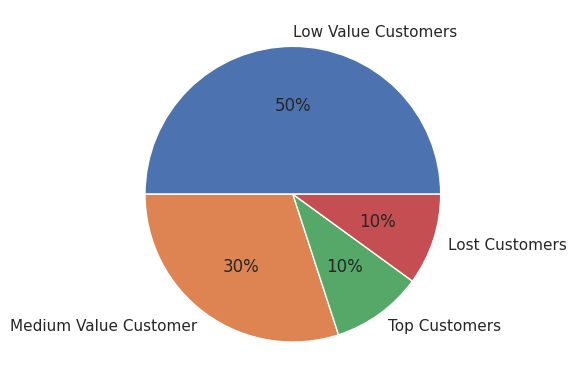

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

In [ ]:
# в целом 50 процентов умеренные страховые

## Хотим посмотреть динамику по месяцам

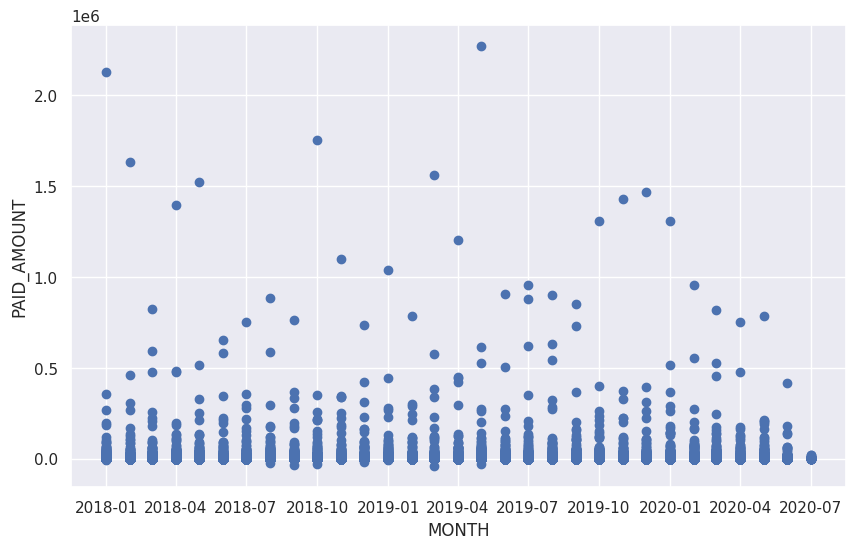

In [47]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df['MONTH'], df['PAID_AMOUNT'])
ax.set_xlabel('MONTH')
ax.set_ylabel('PAID_AMOUNT')
plt.show()

## видим выше несколько выбросов -  в начале 18 и в середине 19 годов

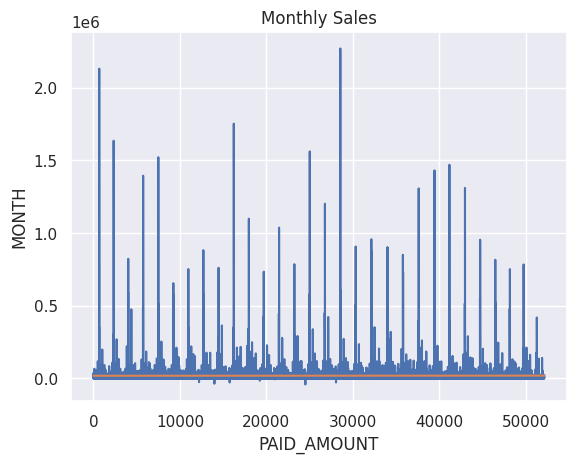

In [52]:
import matplotlib.pyplot as plt

plt.plot(df[['PAID_AMOUNT', 'MONTH']])
plt.xlabel('PAID_AMOUNT')
plt.ylabel('MONTH')
plt.title('Monthly Sales')
plt.show()

In [73]:
df = df.drop(columns=['ClientID', 'Money', 'Date'])
df

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,2018-01-01,AncillaryFFS,NaN,Payer F,4281.0
1,2018-01-01,AncillaryFFS,NaN,Payer H,2221.0
2,2018-01-01,AncillaryFFS,NaN,Payer O,3937.0
3,2018-01-01,AncillaryFFS,NaN,Payer W,268.0
4,2018-01-01,AncillaryFFS,ACH,Payer W,151.0
...,...,...,...,...,...
52147,2020-07-01,SpecialistsFFS,RADIATION ONCOLOGY,Payer F,869.0
52148,2020-07-01,SpecialistsFFS,REGISTERED NURSE,Payer H,99.0
52149,2020-07-01,SpecialistsFFS,RHEUMATOLOGY,Payer F,536.0
52150,2020-07-01,SpecialistsFFS,SPECIAL SERVICES,Payer H,1064.0


TypeError: 'Text' object is not callable

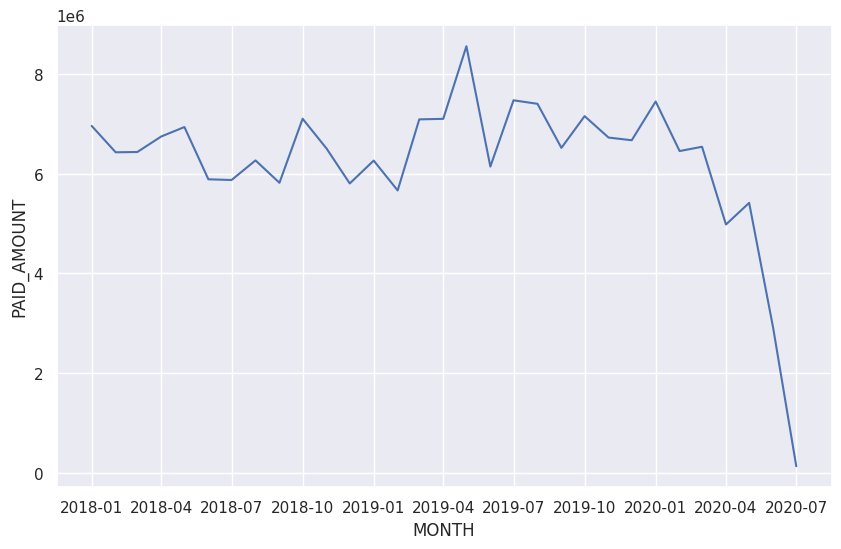

In [76]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(df.groupby('MONTH').sum())
plt.figsize=(15,10)
ax.set_xlabel('MONTH')
ax.set_ylabel('PAID_AMOUNT')
ax.title('Monthly Sales')
plt.show()

In [ ]:
# продажи падают с начала 20 года

In [ ]:
# разобраться почему

In [77]:
df[df['MONTH'] >= '2020-01']

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
42272,2020-01-01,AncillaryFFS,NaN,Payer F,1262.0
42273,2020-01-01,AncillaryFFS,NaN,Payer O,2294.0
42274,2020-01-01,AncillaryFFS,ACUTE SHORT TERM HOSPITAL,Payer CO,41382.0
42275,2020-01-01,AncillaryFFS,Advanced Registered Nurse Prac,Payer UN,1801.0
42276,2020-01-01,AncillaryFFS,ADVANCED RN PRACT,Payer CA,430.0
...,...,...,...,...,...
52147,2020-07-01,SpecialistsFFS,RADIATION ONCOLOGY,Payer F,869.0
52148,2020-07-01,SpecialistsFFS,REGISTERED NURSE,Payer H,99.0
52149,2020-07-01,SpecialistsFFS,RHEUMATOLOGY,Payer F,536.0
52150,2020-07-01,SpecialistsFFS,SPECIAL SERVICES,Payer H,1064.0


In [85]:
df_gr_serv = df.groupby(by=['MONTH', 'SERVICE_CATEGORY']).mean()

In [84]:
df[df['SERVICE_CATEGORY']=='PCPEncounter']
# ПОЧЕМУ 0???

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
1096,2018-01-01,PCPEncounter,Cardiology,Payer UN,0.0
1097,2018-01-01,PCPEncounter,Chiropractic Medicine,Payer UN,0.0
1098,2018-01-01,PCPEncounter,COVERING PHYSICIAN,Payer CA,0.0
1099,2018-01-01,PCPEncounter,Dermatology,Payer UN,0.0
1100,2018-01-01,PCPEncounter,Diagnostics,Payer UN,0.0
...,...,...,...,...,...
51610,2020-06-01,PCPEncounter,Podiatry,Payer UN,0.0
51611,2020-06-01,PCPEncounter,Pulmonology,Payer UN,0.0
51612,2020-06-01,PCPEncounter,Radiology,Payer UN,0.0
51613,2020-06-01,PCPEncounter,Social Worker,Payer UN,0.0


In [90]:
df_gr_serv = df_gr_serv.reset_index()

In [91]:
df_gr_serv[df_gr_serv['MONTH'] >= '2020-01-01']

,MONTH,SERVICE_CATEGORY,PAID_AMOUNT
240,2020-01-01,ASCServices,2063.727273
241,2020-01-01,AncillaryFFS,2175.451524
242,2020-01-01,ERServices,3999.073171
243,2020-01-01,InpatientServices,10956.016502
244,2020-01-01,OutpatientServices,3904.157895
...,...,...,...
304,2020-07-01,OutpatientServices,753.222222
305,2020-07-01,PCPEncounter,0.000000
306,2020-07-01,PCPFFS,4469.000000
307,2020-07-01,SNFServices,410.000000


In [94]:
df_gr_serv[((df_gr_serv['MONTH'] >= '2019-01-01') & (df_gr_serv['MONTH'] <= '2019-07-01'))]

,MONTH,SERVICE_CATEGORY,PAID_AMOUNT
120,2019-01-01,ASCServices,2368.608247
121,2019-01-01,AncillaryFFS,1950.803333
122,2019-01-01,ERServices,2852.503876
123,2019-01-01,InpatientServices,8312.009146
124,2019-01-01,OutpatientServices,3061.897727
...,...,...,...
185,2019-07-01,PCPEncounter,-26.744681
186,2019-07-01,PCPFFS,2533.229167
187,2019-07-01,SNFServices,2857.530612
188,2019-07-01,SpecialistFFS,1029.986842


In [95]:
df.PAID_AMOUNT.min()

-42230.0

In [97]:
df[df['PAID_AMOUNT'] < 0].groupby('MONTH').sum()

,PAID_AMOUNT
MONTH,
2018-01-01,-8970.0
2018-02-01,-5210.0
2018-03-01,-8631.0
2018-04-01,-12204.0
2018-05-01,-5151.0
2018-06-01,-5451.0
2018-07-01,-7266.0
2018-08-01,-29362.0
2018-09-01,-40995.0


In [100]:
df[df['PAID_AMOUNT'] < 0].groupby(by = ['MONTH', 'SERVICE_CATEGORY']).sum()

df[df['PAID_AMOUNT'] < 0].groupby(by = ['PAYER']).sum()

,PAID_AMOUNT
PAYER,
Payer B,-1565.0
Payer CA,-55065.0
Payer CO,-103.0
Payer H,-718.0
Payer UN,-283771.0
Payer W,-110.0


In [ ]:
# почему отрицательное значение? для дальнейшего анализа дропнем 
df.groupby('MONTH').sum()

In [ ]:
# видно, что некоторые страховые хуже остальных

KeyError: 2268611.0

In [ ]:
# среднее для каждой категории и покупателя
# корреляцию 
# поработать с датой, какие тренды 
# прогнать всё через регрессии
# построить прогноз 